In [4]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot

# load the images
(trainX, trainy), (testX, testy) = load_data()

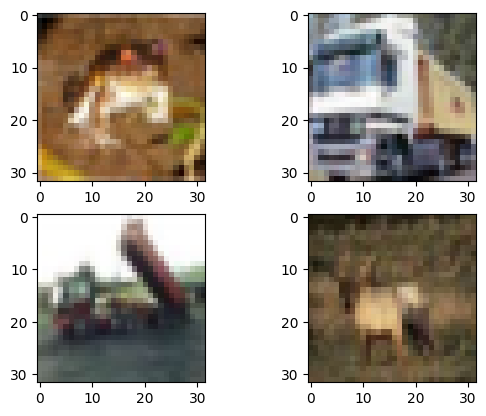

In [5]:
for i in range(4):
    pyplot.subplot(2,2,i+1)
    pyplot.imshow(trainX[i])

In [9]:
# down sample
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D
from  keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.layers import Dense

from keras.utils.vis_utils import plot_model
import numpy as np

In [10]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    #noraml
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    #downsample 
    model.add(Conv2D(128, (3,3), padding='same', strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    #downsample 
    model.add(Conv2D(128, (3,3), padding='same', strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    #downsample 
    model.add(Conv2D(256, (3,3), padding='same', strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [11]:
import pydot
# define model
model = define_discriminator()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 256)        

c:\Users\koush\anaconda3\envs\tfod\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [23]:
# plot the model
import pydot
plot_model(model,to_file='./discriminator_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
def load_real_samples():
    # load from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0, 255] to [-1, 1]
    X = (X - 127.5) / 127.5
    return X

In [25]:
x = load_real_samples()
x.shape

(50000, 32, 32, 3)

In [32]:
def generate_real_samples(dataset, n_sample):
    # print(dataset.shape[0])
    ix = np.random.randint(0, dataset.shape[0], n_sample)
    X = dataset[ix]
    y = np.ones((n_sample, 1))
    return X,y


In [35]:
X,y = generate_real_samples(x, 1)
print(X.shape)
print(y.shape)
print(y)

(1, 32, 32, 3)
(1, 1)
[[1.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


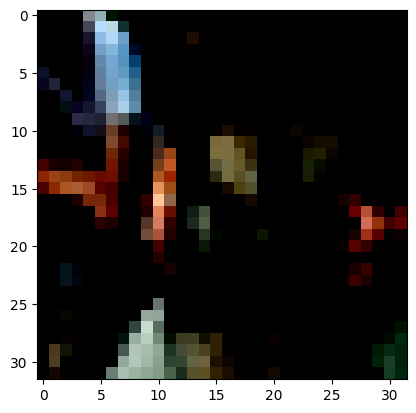

In [39]:
pyplot.imshow(X[0])

In [120]:
# Generate fake samples
def generate_fake_samples(n_samples):
    
    X = np.random.rand(32*32*3*n_samples)

    X = -1 + X*2
    X = X.reshape((n_samples, 32, 32, 3))
    y = np.zeros((n_samples, 1))

    return X, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 32, 32, 3)


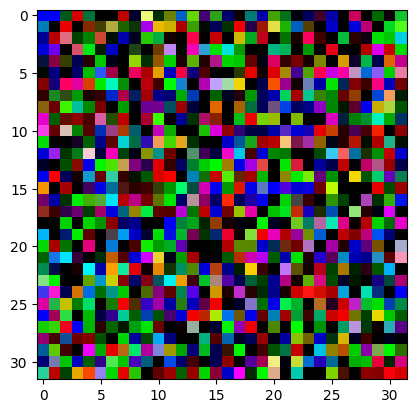

In [129]:
X, y = generate_fake_samples(64)

print(X.shape)
pyplot.imshow(X[10])

In [140]:
# train the discriminator model 
def train_discriminator(model, dataset, n_itel=20, n_batch =128):
    half_batch = int(n_batch / 2)
    for i in range(n_itel):
        X_real, y_real = generate_real_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real)

        X_fake, y_fake = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)

        # summarize performance
        print('>%d, real=%.0f%%  fake=%.0f%%'
              % (i+1, real_acc*100, fake_acc*100))


In [141]:
model = define_discriminator()

dataset = load_real_samples()

train_discriminator(model, dataset)

c:\Users\koush\anaconda3\envs\tfod\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


>1, real=58%  fake=2%
>2, real=95%  fake=3%
>3, real=95%  fake=5%
>4, real=100%  fake=27%
>5, real=100%  fake=61%
>6, real=100%  fake=88%
>7, real=95%  fake=100%
>8, real=97%  fake=100%
>9, real=94%  fake=100%
>10, real=95%  fake=100%
>11, real=92%  fake=100%
>12, real=98%  fake=100%
>13, real=98%  fake=100%
>14, real=100%  fake=100%
>15, real=100%  fake=100%
>16, real=100%  fake=100%
>17, real=98%  fake=100%
>18, real=98%  fake=100%
>19, real=100%  fake=100%
>20, real=100%  fake=100%


In [142]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

In [143]:
def define_generator(latent_dim):
    model = Sequential()

    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #output layer
    model.add(Conv2D(3,(3,3), activation='tanh', padding='same'))
    return model

In [144]:
# define the size of the latent space
latent_dim =100
#define the genetator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

In [147]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    #generate point in the latent space 
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [148]:
x_input = generate_latent_points(100,64)
print(x_input.shape)

(64, 100)
